In [1]:
import os
import numexpr as ne
ne.set_num_threads(32)
ne.set_num_threads(32)
import sys
import cactusLib.cactusUtils as cu
from cactusLib.cactusLib import mapAnalysisObject2 as mao
from cactusLib.cactusCatalogs import readCatalog
import numpy as np
import os
from datetime import datetime
import scipy
from flipper import fftTools
from cactusLib import filterLib
import matplotlib.pyplot as plt
from cactusLib.cactusBeams import getBeamSpline, getBeamNorm
from scipy import ndimage
from cactusLib.filterLib import symmetrizeFFT

/home/cvargas/.local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
/home/cvargas/miniconda2/lib/python2.7/site-packages/photutils/geometry/__init__.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .circular_overlap import *       # noqa
/home/cvargas/miniconda2/lib/python2.7/site-packages/photutils/geometry/__init__.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .elliptical_overlap import *     # noqa
/home/cvargas/miniconda2/lib/python2.7/site-packages/photutils/geometry/__init__.py:8: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .rectangular_overlap import *    # noqa


In [2]:
i = 0

In [3]:
paramfile = "./ar2s2.par"
#simrange = [0,1]
outdir = "test_sim_maps_nr"
catname = "./test_sim_cats/"
tag = "ACT_220_s2_sim_full"
if not os.path.isdir(outdir):
    os.makedirs(outdir)
startTime = datetime.now()
ma = mao(paramfile)
mapData = ma.Map.map.data.copy()
#print "Processing sim %d/%d" % (i+1, simrange[1] - simrange[0])

print "Proccessing sim{}".format(i)

ma.Map.map.data = mapData.copy()


Proccessing sim0


In [4]:
lt = ma.Map.map.copy()
lt.data[:] = lt.data*np.sqrt(ma.Map.weights.data)

mu = 0.
sigma = 1.
Ny,Nx = lt.data.shape
new = np.fft.fft2(np.random.normal(mu,sigma,(Ny,Nx)))
new_exp = new/np.abs(new)

noiseMap = lt.copy()

pad = 100
extraYPad = 0
apodNy,apodNx = noiseMap.data.shape
apod = noiseMap.data.copy()
apod[:] = 0.0
apod[pad+extraYPad:apodNy-pad-extraYPad,pad:apodNx-pad] = 1.0
N_apod = scipy.ndimage.gaussian_filter(apod,20,mode="constant")

#N_apod = ma1.Map.taper.data


noiseMap.data *= N_apod

FTNM = fftTools.fftFromLiteMap(noiseMap)

#Pixel window function
pixW = np.zeros([FTNM.Ny,FTNM.Nx])
pixW[FTNM.iy,FTNM.ix] = np.sinc(FTNM.lx[FTNM.ix]*FTNM.pixScaleX/(2.0*np.pi))*\
                        np.sinc(FTNM.ly[FTNM.iy]*FTNM.pixScaleY/(2.0*np.pi))
#######################

a = np.abs(FTNM.kMap)

#a = a*pixW

M_fft2 = a*new_exp
M_fft2 = filterLib.symmetrizeFFT(M_fft2)
M = np.real(np.fft.ifft2(M_fft2))

#We need a normalization factor since we used the taper
f1 = np.sqrt(np.sum(lt.data**2)/np.sum(M**2))

M *= f1

M = np.divide(M,np.sqrt(ma.Map.weights.data))
M[np.isnan(M)] = 0.
M[np.isinf(M)] = 0.
#dividing back by the weights and fixing nans
ma.Map.map.data = M


/home/cvargas/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in divide


In [29]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [31]:
plt.imshow(np.log10(np.abs(np.fft.fftshift(np.fft.fft2(N_apod)))*N_apod.size))
plt.show()

In [5]:
np.std(M*np.sqrt(ma.Map.weights.data))

93819.75711785837

In [6]:
np.std(lt.data)

93639.19078742212

In [7]:
#np.std(lt.data)/np.std(M*np.sqrt(ma.Map.weights.data))

#Correct the last factor between the generated M with the lose of pixels due to no weights

#f2 = np.sqrt(np.std(lt.data)/np.std(M*np.sqrt(ma.Map.weights.data)))

#M/=f2


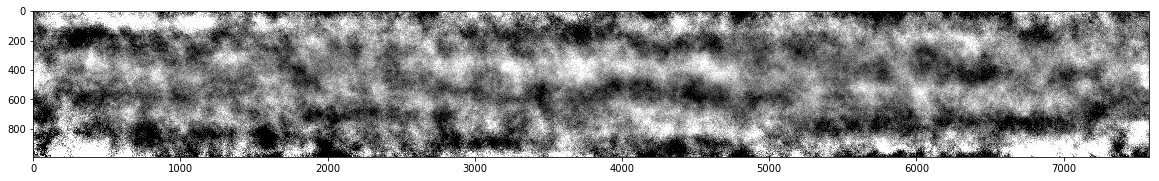

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(M,vmin = -800,vmax = 800,cmap="gray")

In [9]:
notaperstd1 = np.std(M*np.sqrt(ma.Map.weights.data))
taperstd1 = np.std(M*np.sqrt(ma.Map.weights.data)*ma.Map.taper.data)

In [10]:
notaperstd2 = np.std(lt.data)
taperstd2 = np.std(lt.data*ma.Map.taper.data)

In [11]:
ma1 = mao(paramfile)
ma1.Map.map.data = M
ma1.noise.data = M *np.sqrt(ma.Map.weights.data)*ma.Map.taper.data

In [12]:
ma2 = mao(paramfile)
ma2.noise.data = ma2.noise.data*np.sqrt(ma.Map.weights.data)*ma.Map.taper.data

In [13]:
FTNM1 = fftTools.fftFromLiteMap(ma1.noise)

In [14]:
FTNM2 = fftTools.fftFromLiteMap(ma2.noise)

In [15]:
np.sum(np.abs(FTNM1.kMap)**2) 

4.7540068166037774e+23

In [16]:
np.sum(np.abs(FTNM2.kMap)**2) 

4.444766387997804e+23

In [17]:
T_other21 = np.real(FTNM1.kMap*np.conjugate(FTNM1.kMap))
T_other22 = np.real(FTNM2.kMap*np.conjugate(FTNM2.kMap))

In [18]:
beam_ell_file = ma1.params["beamEllFile"]
ellxMin = 100.
ellyMin = 0.
ellMin = 1000.

In [19]:
gFilterSigma = 10.
sigma = np.array([1./FTNM.ly[1], 1./FTNM.lx[1]], dtype=float) * gFilterSigma
smooth1 = ndimage.gaussian_filter(np.fft.fftshift(T_other21), sigma=sigma)
T_other21 = np.fft.ifftshift(smooth1)

smooth2 = ndimage.gaussian_filter(np.fft.fftshift(T_other22), sigma=sigma)
T_other22 = np.fft.ifftshift(smooth2)

# Beam normalization
# Since the beam is normalized in ell space the value at the central pixel
# will be np.sum(Beam_kk)/Beam_kk.size. We want that value to be 1.
# (normalized in real space) so we divide by it and

Beamspl = getBeamSpline(beam_ell_file)
Beam_kk = Beamspl(FTNM.modLMap)
Beam_kk /= getBeamNorm(Beam_kk)

# ell-space mask
lmask = np.ones(FTNM.modLMap.shape)
lmask[:, np.abs(FTNM.lx) < ellxMin] = 0.  # vertical strip
lmask[np.abs(FTNM.ly) < ellyMin] = 0.  # horizontal strip
lmask[FTNM.modLMap < ellMin] = 0.  # low-ell circle

# Filter normalization
Norm1 = np.sum((Beam_kk ** 2) * lmask / T_other21) / Beam_kk.size
Norm2 = np.sum((Beam_kk ** 2) * lmask / T_other22) / Beam_kk.size

kFilter1 = Beam_kk * lmask / T_other21 / Norm1

kFilter1sym = symmetrizeFFT(kFilter1)

kFilter2 = Beam_kk * lmask / T_other22 / Norm2

kFilter2sym = symmetrizeFFT(kFilter2)

/home/cvargas/cactusLib/cactusLib/filterLib.py:687: ComplexWarning: Casting complex values to real discards the imaginary part
  out[0, 1:] = (frx0 + np.flipud(frx0)) / 2. + 1j * (fix0 - np.flipud(fix0)) / 2.
/home/cvargas/cactusLib/cactusLib/filterLib.py:688: ComplexWarning: Casting complex values to real discards the imaginary part
  out[1:, 0] = (fry0 + np.flipud(fry0)) / 2. + 1j * (fiy0 - np.flipud(fiy0)) / 2.
/home/cvargas/cactusLib/cactusLib/filterLib.py:689: ComplexWarning: Casting complex values to real discards the imaginary part
  out[1:, 1:] = (fr11 + np.flipud(np.fliplr(fr11))) / 2. + 1j * (fi11 - np.flipud(np.fliplr(fi11))) / 2.


In [20]:
Norm1

2.989811878884655e-16

In [21]:
Norm2

3.556592121944095e-16

In [22]:
Norm2/Norm1

1.1895705368830352